# Project 1 in Machine Learning, Kernel-trick

**Author:** Antoine Cornaz, Zayneb Melloui, Anas Himmi
**Date:** 1.11.2024

## 1. Introduction

### 1.1 Problem Statement
This machine learning project consists of two main phases. The dataset used contains medical records of patients, both healthy and those diagnosed with cardiovascular disease (CVD). The first phase focuses on implementing the functions covered in class and exercise sessions. The second phase aims to optimize the model for the best possible prediction, simulating a real-world scenario.

### 1.2 Objective

The objective of this project is to develop a machine learning model capable of predicting the presence of cardiovascular disease (CVD) in patients based on their medical information. The performance of the model will be evaluated using the following metrics:
- **Accuracy**: To measure the overall correctness of the model's predictions.
- **F1-Score**: To assess the balance between precision and recall, particularly for the CVD class.
- **Precision**: To evaluate the proportion of true positive predictions among all positive predictions.
- **Recall**: To measure the proportion of true positive predictions among all actual positive instances.

The goal is to optimize the model to achieve the best possible performance on these metrics, but most importantly on the F1-score, simulating real-world predictive scenarios.

### 1.3 Dataset Description
The dataset consists of records from 328,135 patients, each described by 321 dimensions containing various medical information. While none of the patients have all 321 medical fields fully populated, 92 key medical attributes are consistently available for every patient. The data originates from the **Behavioral Risk Factor Surveillance System (BRFSS)**, a health-related telephone survey system that gathers state-level data on U.S. residents. The BRFSS focuses on health-related risk behaviors, chronic health conditions, and the usage of preventive health services. This dataset provides a rich source of information for analyzing cardiovascular disease (CVD) and related health factors.

The description and definition of each feature can be found in the following link : https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf. We can observe that most features are categorical which will lead us to make all of them categorical, and use algorithms that can handle categorical data or use encoding techniques to convert them to numerical data (e.g., one-hot encoding).

## 2. Data Loading and Exploration

## 2.1 Import and Initialisation

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from implementations import *
# from helpers import *
# from visualisation import *
# from preprocessing import *
# from missing import *
# from split import *

# import sys


# %load_ext autoreload
# %autoreload 2

In [2]:
x_train = np.genfromtxt("data/x_train.csv", delimiter=",", skip_header=1)
features = np.genfromtxt("data/x_train.csv", delimiter=",", dtype=str, max_rows=1)
y_train = np.genfromtxt("data/y_train.csv", delimiter=",", skip_header=1)
y_features = np.genfromtxt("data/y_train.csv", delimiter=",", dtype=str, max_rows=1)

In [3]:
x_test = np.genfromtxt("data/x_test.csv",delimiter=",", skip_header=1)

## 2.2 Data Preprocessing

In [4]:
def to_categorical(array, range_min, range_max, n_bins):
    """
    Converts a numerical array into categorical bins based on specified range and number of bins.
    Parameters:
    array (numpy.ndarray): The input array containing numerical values.
    range_min (float): The minimum value of the range to consider for binning.
    range_max (float): The maximum value of the range to consider for binning.
    n_bins (int): The number of bins to divide the range into.
    Returns:
    function: A function that takes a value and returns the corresponding bin index or the value itself if it is outside the specified range.
              If the value is NaN, it returns -1.
    Notes:
    - Values outside the specified range are returned as is.
    - NaN values are assigned a bin index of -1.
    - Bin edges are calculated using quantiles to ensure approximately equal distribution of values across bins.
    - The rightmost bin includes values exactly equal to range_max.
    """
    # Filter array to include only values within the specified range
    filtered_values = array[(array >= range_min) & (array <= range_max)]
    
    # Calculate the bin edges using quantiles
    bin_edges = np.quantile(filtered_values, np.linspace(0, 1, n_bins + 1))
    
    def assign_bin(value):
        # Check if the value is NaN
        if np.isnan(value):
            return -1
        
        # If the value is outside the range, return it as is
        if value < range_min or value > range_max:
            return value
        
        # Assign bin based on which range the value falls into
        # We use right=True to ensure that values exactly equal to range_max are included in the last bin
        return np.digitize(value, bin_edges, right=True)
    
    return assign_bin



# a dictionary that maps the column names to the corresponding mapping function
# - For naturally categorical, we map the NaN values to -1
# - For numerical, we check the codebook for all possible values 
#   and map the range of numerical values to a range of bins (e.g. 0-30 to 4 bins) 
#   then map the rest to their own category (don't know, didn't want to answer, Nan etc.)
# We only keep vaguely relevant columns to our problem. We will further refine this list later.

mapping_dict = {
    "GENHLTH": lambda value: value if not np.isnan(value) else -1,
    "PHYSHLTH": to_categorical(array=x_train[:, features=="PHYSHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "MENTHLTH": to_categorical(array=x_train[:, features=="MENTHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "POORHLTH": to_categorical(array=x_train[:, features=="POORHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "HLTHPLN1": lambda value: value if not np.isnan(value) else -1,
    "MEDCOST": lambda value: value if not np.isnan(value) else -1,
    "CHECKUP1": lambda value: value if not np.isnan(value) else -1,
    "BPHIGH4": lambda value: value if not np.isnan(value) else -1,
    "BPMEDS": lambda value: value if not np.isnan(value) else -1,
    "BLOODCHO": lambda value: value if not np.isnan(value) else -1,
    "CHOLCHK": lambda value: value if not np.isnan(value) else -1,
    # "CVDINFR4": lambda value: 1 if value == 1 else 0,
    # "CVDCRHD4": lambda value: 1 if value == 1 else 0,
    "TOLDHI2": lambda value: value if not np.isnan(value) else -1,
    "CVDSTRK3": lambda value: value if not np.isnan(value) else -1,
    "ASTHMA3": lambda value: value if not np.isnan(value) else -1,
    "ASTHNOW": lambda value: value if not np.isnan(value) else -1,
    "CHCSCNCR": lambda value: value if not np.isnan(value) else -1,
    "CHCOCNCR": lambda value: value if not np.isnan(value) else -1,
    "CHCCOPD1": lambda value: value if not np.isnan(value) else -1,
    "HAVARTH3": lambda value: value if not np.isnan(value) else -1,
    "ADDEPEV2": lambda value: value if not np.isnan(value) else -1,
    "CHCKIDNY": lambda value: value if not np.isnan(value) else -1,
    "DIABETE3": lambda value: value if not np.isnan(value) else -1,
    "SEX": lambda value: value if not np.isnan(value) else -1,
    "MARITAL": lambda value: value if not np.isnan(value) else -1,
    "EDUCA": lambda value: value if not np.isnan(value) else -1,
    "VETERAN3": lambda value: value if not np.isnan(value) else -1,
    "INCOME2": lambda value: value if not np.isnan(value) else -1,
    "INTERNET": lambda value : value if not np.isnan(value) else -1,
    "WTKG3": to_categorical(array=x_train[:, features=="WTKG3"].flatten(), range_min=23, range_max=295, n_bins=6),
    "QLACTLM2": lambda value : value if not np.isnan(value) else -1,
    "USEEQUIP": lambda value : value if not np.isnan(value) else -1,
    "BLIND": lambda value : value if not np.isnan(value) else -1,
    "DECIDE": lambda value : value if not np.isnan(value) else -1,
    "DIFFWALK": lambda value : value if not np.isnan(value) else -1,
    "DIFFDRES": lambda value : value if not np.isnan(value) else -1,
    "DIFFALON": lambda value : value if not np.isnan(value) else -1,
    "SMOKE100": lambda value : value if not np.isnan(value) else -1,
    "SMOKDAY2": lambda value : value if not np.isnan(value) else -1,
    "LASTSMK2": lambda value : value if not np.isnan(value) else -1,
    "USENOW3": lambda value : value if not np.isnan(value) else -1,
    "AVEDRNK2": to_categorical(array=x_train[:, features=="AVEDRNK2"].flatten(), range_min=1, range_max=76, n_bins=5),
    "DRNK3GE5": to_categorical(array=x_train[:, features=="DRNK3GE5"].flatten(), range_min=1, range_max=76, n_bins=5),
    "EXERANY2": lambda value : value if not np.isnan(value) else -1,
    # "EXERHMM1": lambda value: str(value//200) if value <= 959 and value not in [777,999] else -1,
    "LMTJOIN3": lambda value : value if not np.isnan(value) else -1,
    "FLUSHOT6": lambda value : value if not np.isnan(value) else -1,
    "PDIABTST": lambda value : value if not np.isnan(value) else -1,
    "PREDIAB1": lambda value : value if not np.isnan(value) else -1,
    "INSULIN": lambda value : value if not np.isnan(value) else -1,
    "CIMEMLOS": lambda value : value if not np.isnan(value) else -1,
    "_RFHLTH": lambda value : value if not np.isnan(value) else -1,
    "_HCVU651": lambda value : value if not np.isnan(value) else -1,
    "_RFHYPE5": lambda value : value if not np.isnan(value) else -1,
    "_CHOLCHK": lambda value : value if not np.isnan(value) else -1,
    "_RFCHOL": lambda value : value if not np.isnan(value) else -1,
    # "_MICHD": lambda value: value if value <= 2 else -1,
    "_LTASTH1": lambda value : value if not np.isnan(value) else -1,
    "_CASTHM1": lambda value : value if not np.isnan(value) else -1,
    "_DRDXAR1": lambda value : value if not np.isnan(value) else -1,
    "_AGEG5YR": lambda value : value if not np.isnan(value) else -1,
    "_AGE_G": lambda value : value if not np.isnan(value) else -1,
    "HTM4": to_categorical(array=x_train[:, features=="HTM4"].flatten(), range_min=0.91, range_max=2.44, n_bins=6),
    "_RFBMI5": lambda value : value if not np.isnan(value) else -1,
    "_EDUCAG": lambda value : value if not np.isnan(value) else -1,
    "_SMOKER3": lambda value : value if not np.isnan(value) else -1,
    "_RFBING5": lambda value : value if not np.isnan(value) else -1,
    "_BMI5CAT": lambda value : value if not np.isnan(value) else -1,
    "_RFDRHV5": lambda value : value if not np.isnan(value) else -1,
    "FTJUDA1_": to_categorical(array=x_train[:, features=="FTJUDA1_"].flatten(), range_min=0, range_max=99.99, n_bins=4),
    "MAXVO2_": to_categorical(array=x_train[:, features=="MAXVO2_"].flatten(), range_min=0, range_max=50.1, n_bins=6),
    "ACTIN11_": lambda value : value if not np.isnan(value) else -1,
    "ACTIN21_": lambda value : value if not np.isnan(value) else -1,
    "_PACAT1": lambda value : value if not np.isnan(value) else -1,
    "_PA150R2": lambda value : value if not np.isnan(value) else -1,
    "_PA300R2": lambda value : value if not np.isnan(value) else -1,
    "_PASTRNG":  lambda value : value if not np.isnan(value) else -1,
    "_PASTAE1": lambda value : value if not np.isnan(value) else -1,
    "_LMTACT1": lambda value : value if not np.isnan(value) else -1,
    "_LMTWRK1": lambda value : value if not np.isnan(value) else -1,
    "_LMTSCL1": lambda value : value if not np.isnan(value) else -1,
    "_INCOMG": lambda value : value if not np.isnan(value) else -1,
}

In [5]:
# Not necessary because we will do a greedy approach later (unless we want to save time)
def select_features_with_low_nan_ratio(X, features_to_check, threshold=0.1):
    """
    Select features from the training data that have a NaN ratio below a specified threshold.

    Parameters:
    X (numpy.ndarray): The feature data array.
    features_to_check (list): List of features to check for NaN ratios.
    threshold (float): The maximum allowable NaN ratio for a feature to be selected. Default is 0.1.

    Returns:
    list: A list of features that have a NaN ratio below the specified threshold.
    """
    nan_ratios = {}
    for feature in features_to_check:
        nan_ratios[feature] = np.sum(np.isnan(X[:, features == feature])) / len(X)

    selected_features = [feature for feature in nan_ratios if nan_ratios[feature] < threshold]

    # print(f"Selected {len(selected_features)} features over {len(features_to_check)}")
    # print(nan_ratios)
    return selected_features

# This is the function that applies the mapping to the selected features
def apply_mapping(X, selected_features, mapping_dict):
    """
    Applies a mapping function to selected features in the training data.

    Parameters:
    X (numpy.ndarray): The feature data array of shape (n_samples, n_features).
    selected_features (list): A list of feature indices to which the mapping functions will be applied (they need to be keys of mapping_dict)
    mapping_dict (dict): A dictionary where keys are feature indices and values are functions that map feature values.

    Returns:
    numpy.ndarray: A new array with the same number of samples as X but only the selected features, 
                   with the mapping functions applied to each feature.
    """
    X_filtered = np.zeros((X.shape[0], len(selected_features)))
    for feature in selected_features:
        feature_values = X[:, features == feature].flatten()
        if feature_values.size > 0:
            X_filtered[:, selected_features.index(feature)] = np.array([mapping_dict[feature](value) for value in feature_values])
    return X_filtered

We can observe that the target variable is imbalanced, with a higher number of healthy patients compared to those diagnosed with CVD. This imbalance can affect the model's performance, particularly in terms of recall and F1-score. Therefore, we will address this issue by oversampling the minority class by duplicating randomly selected instances from the CVD class.

In [6]:
# Proportion of Y=1 in the training set vs Y=-1
number_of_ones = np.sum(y_train == 1)
number_of_minus_ones = np.sum(y_train == -1)
total = len(y_train)
print(f"Proportion of Y=1: {number_of_ones/total*100:.2f}%")

Proportion of Y=1: 8.83%


In [7]:
def fix_class_imbalance(X, y, target_value=1, dont_balance=False):
    """
    Fix class imbalance by oversampling the minority class or undersampling the majority class.
    
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features)
    y (numpy.ndarray): Target vector of shape (n_samples,), containing values -1 and 1
    target_value (int): Class value to balance to (default is 1)
    dont_balance (bool): If True, the function will not balance the classes (default is False)
    
    Returns:
    X_balanced (numpy.ndarray): Feature matrix with balanced classes
    y_balanced (numpy.ndarray): Balanced target vector
    """
    if dont_balance:
        return X, y

    # Separate samples by class
    class_1_indices = np.where(y == target_value)[0]
    class_minus_1_indices = np.where(y != target_value)[0]
    
    # Find class counts
    class_1_count = len(class_1_indices)
    class_minus_1_count = len(class_minus_1_indices)
    
    if class_1_count == class_minus_1_count:
        # If classes are already balanced, return the original data
        return X, y
    
    elif class_1_count < class_minus_1_count:
        # If class 1 is the minority, oversample class 1
        oversample_size = class_minus_1_count - class_1_count
        oversampled_indices = np.random.choice(class_1_indices, oversample_size, replace=True)
        new_indices = np.concatenate([np.arange(len(y)), oversampled_indices])
    else:
        # If class -1 is the minority, oversample class -1
        oversample_size = class_1_count - class_minus_1_count
        oversampled_indices = np.random.choice(class_minus_1_indices, oversample_size, replace=True)
        new_indices = np.concatenate([np.arange(len(y)), oversampled_indices])
    
    # Create the balanced dataset
    X_balanced = X[new_indices]
    y_balanced = y[new_indices]
    
    return X_balanced, y_balanced

We will implement here a LabelEncoder to simplify the design of algorithms and a OneHotEncoder to convert the categorical features into numerical data.

In [8]:
def one_hot_encode(X, selected_features):
    """
    One-hot encodes the selected features in the input matrix X.

    Parameters:
    X (ndarray): The input feature matrix of shape (n_samples, n_features).
    selected_features (list): A list of selected feature indices for one-hot encoding.

    Returns:
    ndarray: A matrix containing the one-hot encoded columns.
    """
    # Initialize a list to collect the one-hot encoded columns
    one_hot_encoded_list = []

    # Iterate over the final selected features
    for i, feature in enumerate(selected_features):
        # Extract feature values for the current feature
        feature_values = X[:, i]
        
        # Get unique values for this feature
        unique_values = np.unique(feature_values)
        
        # One-hot encode by creating a column for each unique value and append to the list
        one_hot_encoded_columns = [(feature_values == value).astype(int).reshape(-1, 1) for value in unique_values]
        one_hot_encoded_list.extend(one_hot_encoded_columns)
    
    # Concatenate all one-hot encoded columns horizontally
    X_OHE = np.hstack(one_hot_encoded_list)
    
    return X_OHE

def label_encode(X, selected_features):
    """
    Label encodes the selected features in the input matrix X.

    Parameters:
    X (ndarray): The input feature matrix of shape (n_samples, n_features).
    selected_features (list): A list of selected feature indices for label encoding.

    Returns:
    ndarray: A matrix containing the label encoded columns.
    """
    # Initialize a list to collect the label encoded columns
    label_encoded_list = []

    # Iterate over the final selected features
    for i, feature in enumerate(selected_features):
        # Extract feature values for the current feature
        feature_values = X[:, i]
        
        # Get unique values for this feature
        unique_values = np.unique(feature_values)
        
        # Label encode by mapping each unique value to an integer from 0 to n_categories - 1
        label_encoded_column = np.array([np.where(unique_values == value)[0][0] for value in feature_values]).reshape(-1, 1)
        label_encoded_list.append(label_encoded_column)
    
    # Concatenate all label encoded columns horizontally
    X_LE = np.hstack(label_encoded_list)
    
    return X_LE

We also will map the target variable to 0 and 1, where 0 represents healthy patients and 1 represents patients diagnosed with CVD because the logistic regression algorithm requires it.

In [9]:
def map_y_to_0_1(y):
    """
    Maps the target values from -1 and 1 to 0 and 1.

    Parameters:
    y (ndarray): The target vector containing values -1 and 1.

    Returns:
    ndarray: The target vector with values 0 and 1.
    """
    return (y + 1) // 2

def map_y_to_minus_1_1(y):
    """
    Maps the target values from 0 and 1 to -1 and 1.

    Parameters:
    y (ndarray): The target vector containing values 0 and 1.

    Returns:
    ndarray: The target vector with values -1 and 1.
    """
    return 2 * y - 1

## 2.3 Feature Importance

We calculate the normalized mutual information between each feature and the target variable to identify the most relevant features for predicting CVD. This information will guide us in selecting the most important features for training the model.

In [10]:
import numpy as np

def calculate_feature_entropies(x_train_filtered, y_train, selected_features):
    # Function to calculate entropy
    def calculate_entropy(probabilities):
        # Calculate entropy: H(X) = -sum(p(x) * log2(p(x)))
        assert np.isclose(np.sum(probabilities), 1), f"Probabilities do not sum to 1: {np.sum(probabilities)}"
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    entropies = []
    entropies_normalized = []
    joint_entropies = []
    joint_entropies_normalized = []
    mutual_informations = []
    NMI = []

    # Filter the rows based on target values
    Y1 = x_train_filtered[y_train[:, 1] == 1]
    Y_minus1 = x_train_filtered[y_train[:, 1] == -1]

    # Total counts for probabilities
    count_Y1 = len(Y1)
    count_Y_minus1 = len(Y_minus1)
    total_count = count_Y1 + count_Y_minus1

    # Calculate probabilities of Y
    p_Y1 = count_Y1 / total_count
    p_Y_minus1 = count_Y_minus1 / total_count

    # Entropy of Y
    entropy_Y = calculate_entropy([p_Y1, p_Y_minus1])

    # Iterate over the indices of the features
    for feature in selected_features:
        feature_index = selected_features.index(feature)
        # Get the feature values for the entire dataset (to find all unique values)
        all_feature_values = x_train_filtered[:, feature_index]
        unique_values_all, counts_all = np.unique(all_feature_values, return_counts=True)

        # Get the feature values for the filtered rows where Y=1
        feature_values_Y1 = Y1[:, feature_index]
        non_nan_values_Y1 = feature_values_Y1[~np.isnan(feature_values_Y1)]

        # Get the counts for each unique value in filtered rows where Y=1
        unique_values_filtered_Y1, counts_filtered_Y1 = np.unique(non_nan_values_Y1, return_counts=True)

        # Create a dictionary for filtered counts where Y=1
        filtered_count_dict_Y1 = dict(zip(unique_values_filtered_Y1, counts_filtered_Y1))

        # Initialize the probabilities list for Y=1
        probabilities_Y1 = []

        # Calculate probabilities for Y=1
        for value in unique_values_all:
            count = filtered_count_dict_Y1.get(value, 0)  # Default to 0 if not found
            probabilities_Y1.append(count / np.sum(counts_filtered_Y1) if np.sum(counts_filtered_Y1) > 0 else 0)  # Probabilities

        # Compute the entropy for Y=1
        entropy_Y1 = calculate_entropy(probabilities_Y1)

        # Get the feature values for the filtered rows where Y=-1
        feature_values_Y_minus1 = Y_minus1[:, feature_index]
        non_nan_values_Y_minus1 = feature_values_Y_minus1[~np.isnan(feature_values_Y_minus1)]

        # Get the counts for each unique value in filtered rows where Y=-1
        unique_values_filtered_Y_minus1, counts_filtered_Y_minus1 = np.unique(non_nan_values_Y_minus1, return_counts=True)

        # Create a dictionary for filtered counts where Y=-1
        filtered_count_dict_Y_minus1 = dict(zip(unique_values_filtered_Y_minus1, counts_filtered_Y_minus1))

        # Initialize the probabilities list for Y=-1
        probabilities_Y_minus1 = []

        # Calculate probabilities for Y=-1
        for value in unique_values_all:
            count = filtered_count_dict_Y_minus1.get(value, 0)  # Default to 0 if not found
            probabilities_Y_minus1.append(count / np.sum(counts_filtered_Y_minus1) if np.sum(counts_filtered_Y_minus1) > 0 else 0)  # Probabilities

        # Compute the entropy for Y=-1
        entropy_Y_minus1 = calculate_entropy(probabilities_Y_minus1)

        # Calculate the joint entropy H(f|Y)
        joint_entropy = (p_Y1 * entropy_Y1) + (p_Y_minus1 * entropy_Y_minus1)

        # Normalize entropies
        entropy_normalized_Y1 = entropy_Y1 / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0
        entropy_normalized_Y_minus1 = entropy_Y_minus1 / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0

        # Append results
        entropies.append((entropy_Y1, entropy_Y_minus1))
        entropies_normalized.append((entropy_normalized_Y1, entropy_normalized_Y_minus1))
        joint_entropies.append(joint_entropy)
        joint_entropies_normalized.append(joint_entropy / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0)

        # Mutual information = H(F) - H(F|Y)
        entropy_feature = calculate_entropy(counts_all / np.sum(counts_all))
        mutual_information = (entropy_feature - joint_entropy) / np.log2(len(unique_values_all))
        mutual_informations.append(mutual_information)

        # Normalized mutual information
        NMI.append(2 * mutual_information / (entropy_Y + entropy_feature))

    return entropies, entropies_normalized, joint_entropies, joint_entropies_normalized, mutual_informations, NMI

all_features = list(mapping_dict.keys())
x_train_filtered = apply_mapping(x_train, all_features, mapping_dict)

entropies, entropies_normalized, joint_entropies, joint_entropies_normalized, mutual_informations, NMI = calculate_feature_entropies(x_train_filtered, y_train, all_features)

In [11]:
print(np.sum(NMI))

0.5400431686644592


[('GENHLTH', 0.011372890308499821), ('PHYSHLTH', 0.005606052144614916), ('MENTHLTH', 0.0010073867855778646), ('POORHLTH', 0.00366851995405314), ('HLTHPLN1', 0.0015925699351870635), ('MEDCOST', 0.0003081076536101091), ('CHECKUP1', 0.0021290749718682936), ('BPHIGH4', 0.015498997023659125), ('BPMEDS', 0.019267635898967392), ('BLOODCHO', 0.006956033953880671), ('CHOLCHK', 0.005693564802715609), ('TOLDHI2', 0.01237341942537317), ('CVDSTRK3', 0.02816824772263489), ('ASTHMA3', 0.0016497472672407046), ('ASTHNOW', 0.001564798171259762), ('CHCSCNCR', 0.004113376120738742), ('CHCOCNCR', 0.004828329350552296), ('CHCCOPD1', 0.021124291494311827), ('HAVARTH3', 0.011756126222333537), ('ADDEPEV2', 0.0027441504990411212), ('CHCKIDNY', 0.01350056865769127), ('DIABETE3', 0.011512512856022677), ('SEX', 0.005068909697124422), ('MARITAL', 0.0036540298199253386), ('EDUCA', 0.0015638338373940759), ('VETERAN3', 0.007317295465853785), ('INCOME2', 0.0015029038610149315), ('INTERNET', 0.009257085421347786), ('WTK

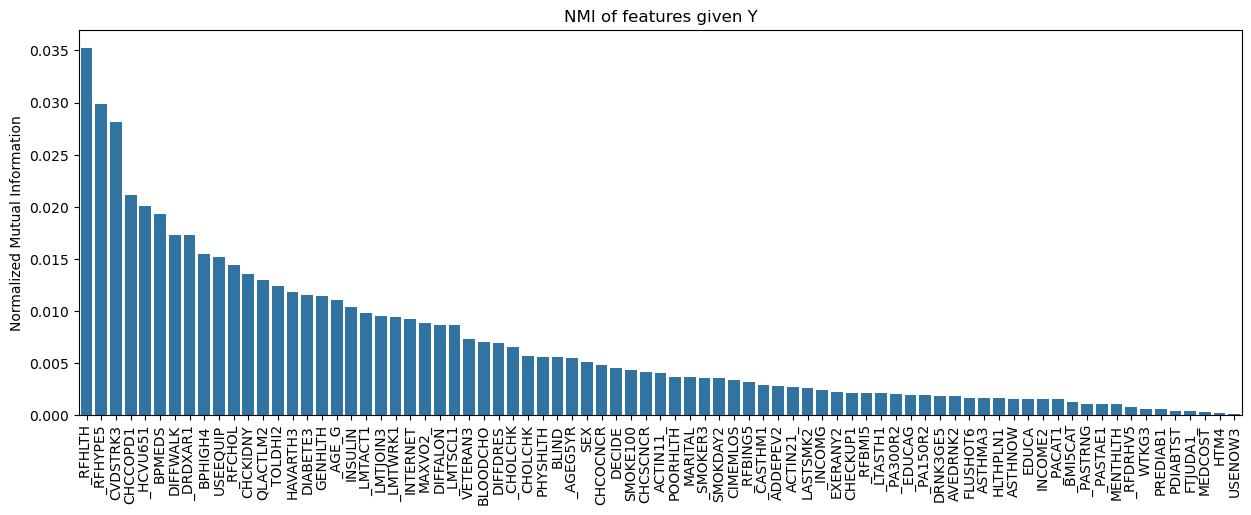

In [12]:
import seaborn as sns
# print the entropies with the corresponding feature
print(list(zip(all_features, NMI)))

# plot the NMI in seaborn in a bar plot (sorted by entropy)
# Sort the features by entropy
sorted_indices = np.argsort(NMI)[::-1]
sorted_features = [all_features[i] for i in sorted_indices]
sorted_entropies = [NMI[i] for i in sorted_indices]

# Plot the entropies
plt.figure(figsize=(15, 5))
sns.barplot(x=sorted_features, y=sorted_entropies)
plt.xticks(rotation=90)
plt.ylabel('Normalized Mutual Information')
plt.title('NMI of features given Y')
plt.show()

We observe from this that the most dependent features to the target are :
- _RFHLTH : Adults with good or better health
- _RFHYPE5 : Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional
- CVDSTRK3 : "(Ever told) you had a stroke"
- CHCCOPD1 : "(Ever told) you have Chronic Obstructive Pulmonary Disease or COPD, emphysema or chronic bronchitis?"

Because our implementations are slow when using all the features, we will use only the most important features to train the model.

In [13]:
# keep features with NMI > 0.015
features_good_nmi = [feature for feature, nmi in zip(all_features, NMI) if nmi > 0.015]
print(f"Selected {len(features_good_nmi)} features out of {len(all_features)}")
print(features_good_nmi)

Selected 10 features out of 79
['BPHIGH4', 'BPMEDS', 'CVDSTRK3', 'CHCCOPD1', 'USEEQUIP', 'DIFFWALK', '_RFHLTH', '_HCVU651', '_RFHYPE5', '_DRDXAR1']


# 3. Train/Test Split

## 3.1 Splitting the Dataset

In [14]:
def split_data_k_folds(x, y, n_folds=4):
    """
    Splits the dataset into k folds for cross-validation.
    Parameters:
    x (numpy.ndarray): The input features of the dataset.
    y (numpy.ndarray): The target labels of the dataset.
    n_folds (int, optional): The number of folds to split the data into. Default is 5.
    Returns:
    list of tuples: A list where each tuple contains four elements:
        - x_train (numpy.ndarray): Training set features for the current fold.
        - y_train (numpy.ndarray): Training set labels for the current fold.
        - x_test (numpy.ndarray): Test set features for the current fold.
        - y_test (numpy.ndarray): Test set labels for the current fold.
    """
    # Shuffle the data
    indices = np.random.permutation(x.shape[0])
    
    # Split indices into n equal-sized parts
    fold_sizes = np.full(n_folds, x.shape[0] // n_folds, dtype=int)  # Base size of each fold
    fold_sizes[:x.shape[0] % n_folds] += 1  # Distribute the remainder

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]  # Select current fold as test set
        train_indices = np.concatenate([indices[:start], indices[stop:]])  # Rest are training
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        folds.append((x_train, y_train, x_test, y_test))
        
        current = stop

    return folds

# 5. Model Selection and Training

## 5.1 Implementing the models

We will implement and compare the following models:
- **Logistic Regression**
- **Categorical Naive Bayes Classifier**
- **Random Forest Classifier**

This is because they are relatively simple to implement, they can handle categorical data (except for Logistic Regression that will need one hot encoding), and they are suitable for binary classification tasks.

In [15]:
class LogisticRegression:
    def __init__(self, max_iters=1000, gamma=0.01, lambda_=0.1):
        self.max_iters = max_iters
        self.gamma = gamma
        self.lambda_ = lambda_
        self.w = None

    def fit(self, X, y):
        self.w, _ = reg_logistic_regression(y, X, self.lambda_, np.zeros(X.shape[1]), self.max_iters, self.gamma)

    def predict(self, X):
        return np.array([1 if p > 0.5 else 0 for p in sigmoid(X @ self.w)])
    
class CategoricalNaiveBayes:
    def __init__(self, smoothing=1e-6):
        self.class_probs = None
        self.feature_probs = None
        self.classes = None
        self.smoothing = smoothing  # Smoothing factor for Laplace smoothing

    def fit(self, X, y):
        # Get the unique classes and initialize dictionaries to store probabilities
        self.classes = np.unique(y)
        num_classes = len(self.classes)
        
        # Calculate class probabilities P(y)
        self.class_probs = np.array([(y == c).mean() for c in self.classes])

        # Calculate feature probabilities P(X|y) for each feature and class
        num_features = X.shape[1]
        self.feature_probs = {}

        for feature_idx in range(num_features):
            feature_values = np.unique(X[:, feature_idx])
            self.feature_probs[feature_idx] = {}
            
            for class_idx, class_value in enumerate(self.classes):
                self.feature_probs[feature_idx][class_value] = {}
                
                # Filter X by class to get only relevant rows
                X_class = X[y == class_value, feature_idx]
                
                for value in feature_values:
                    # Calculate P(feature=value | class) with smoothing
                    prob = ((X_class == value).sum() + self.smoothing) / (len(X_class) + len(feature_values) * self.smoothing)
                    self.feature_probs[feature_idx][class_value][value] = prob

    def predict(self, X):
        # Initialize predictions list
        predictions = []
        
        for row in X:
            # Calculate log-probabilities for each class
            class_log_probs = []
            
            for class_idx, class_value in enumerate(self.classes):
                # Start with log of the class probability
                log_prob = np.log(self.class_probs[class_idx])
                
                for feature_idx in range(len(row)):
                    feature_value = row[feature_idx]
                    # Get the feature probability P(X|y), apply smoothing if not present
                    feature_prob = self.feature_probs[feature_idx][class_value].get(feature_value, self.smoothing)
                    log_prob += np.log(feature_prob)
                
                class_log_probs.append(log_prob)
            
            # Predict the class with the highest log-probability
            predictions.append(self.classes[np.argmax(class_log_probs)])
        
        return np.array(predictions)
    
class RandomForest:

    class Tree:

        def __init__(self, max_depth=3, min_sample_split=2):
            self.max_depth = max_depth
            self.min_sample_split = min_sample_split
            self.root = None

        def fit(self, x, y, depth=0):
            if len(y) == 0:
                return None
            
            if x.shape[0] < self.min_sample_split or len(set(y)) == 1 or depth >= self.max_depth:
                leaf_value = self._calculate_leaf_value(y)
                self.root = RandomForest.TreeNode(value=leaf_value)
                return self.root
        
            best_features, best_threshold = self._best_split(x, y)

            left_x = x[:, best_features] <= best_threshold
            right_x = x[:, best_features] > best_threshold

            left_subtree = self.fit(x[left_x], y[left_x], depth + 1)
            right_subtree = self.fit(x[right_x], y[right_x], depth + 1)

            self.root = RandomForest.TreeNode(best_features, best_threshold, left_subtree, right_subtree)
            return self.root


        def predict(self, x):
            return self._traverse_tree(x, self.root)

        def _traverse_tree(self, x, treeNode):
            if treeNode.value is not None:
                return np.full((x.shape[0],), treeNode.value)  

            # Go right or left
            left_indices = x[:, treeNode.feature_index] <= treeNode.threshold
            right_indices = x[:, treeNode.feature_index] > treeNode.threshold

            # empty array for now
            predictions = np.empty(x.shape[0])

            # predict for left and right subtree
            if np.any(left_indices):
                predictions[left_indices] = self._traverse_tree(x[left_indices], treeNode.left)
            if np.any(right_indices):
                predictions[right_indices] = self._traverse_tree(x[right_indices], treeNode.right)

            return predictions
            
        def _calculate_leaf_value(self, y):
            value, count = np.unique(y, return_counts=True)
            return value[np.argmax(count)]

        def _gini_impurity(self, y):
            D = len(y)
            #print("N", D)
            _, count = np.unique(y, return_counts=True, axis=0)
            #print("Count", count.shape)
            gini = 1 - np.sum((count / D) ** 2)
            #print("gini", gini.shape)
            return gini
    
        def _entropy(self, y):
            N = y.shape
            _, count = np.unique(y, return_counts=True)
            p = count/N
            
            entropy = np.where(p > 0, -p* np.log2(p), 0)
            
            return entropy.sum()
        
        def _split(self, x, feature, threshold):
            #print(threshold[:,np.newaxis].shape)
            #print(x[np.newaxis, :,feature].shape)
            left_branch = np.where(x[:,feature] <= threshold)[0]
            right_branch = np.where(x[:, feature] > threshold)[0]
            #print("left_b", left_branch)
            return left_branch, right_branch
        
        def _best_split(self, x, y):
            best_features = 0
            best_threshold = 0
            best_gini_impurity = 1

            N, D = x.shape

            for i in range(D):
                unique = np.unique(x[:, i])
                unique = np.sort(unique)
                
                # Calculate midpoint between possible value
                threshold = (unique[:-1] + unique[1:])/2
                #print("threshold", threshold)

                """
                l, r = self._split(x, i, threshold)
                print("l", l)
                print("r", r)
                y_prime = y[np.newaxis,:] * np.ones(l.shape)
                print("y'", y_prime)
                print("y'", y_prime)

                gini_left = self._gini_impurity(y_prime[l])
                gini_right = self._gini_impurity(y_prime[r])
                print(gini_left)
                print(gini_right)
                

                break
                """
                for t in threshold:
                    l, r = self._split(x, i, t)
                    gini_left = self._gini_impurity(y[l])
                    gini_right = self._gini_impurity(y[r])
                    gini = (gini_left * len(l) + gini_right * len(r))/N
                    if gini < best_gini_impurity:
                        best_gini_impurity = gini
                        best_features = i
                        best_threshold = t 
            return best_features, best_threshold

    def __init__(self, n_trees=20, max_depth=10, min_samples_split=2, seed=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.rng = np.random.default_rng(seed)

    def fit(self, x, y):
        # Create the trees
        self.list_tree = []
        for i in range(self.n_trees):
            bootstrap_x, bootstrap_y = self._bootstrap_sample(x, y)
            tree = RandomForest.Tree(self.max_depth, self.min_samples_split)
            tree.fit(bootstrap_x, bootstrap_y)
            self.list_tree.append(tree)
        

    def predict(self, x):
        predictions = np.zeros((len(x), self.n_trees))
        for i in range(self.n_trees):
            pred = self.list_tree[i].predict(x)
            #Convert -1 in 0
            predictions[:, i] = np.where(pred == -1, 0, 1)
        dominant_prediction = np.apply_along_axis(lambda p: np.bincount(p.astype(int)).argmax(), axis=1, arr=predictions)
        # Convert back 0 in -1
        dominant_prediction = np.where(dominant_prediction == 0, -1, 1)
        return dominant_prediction

    class TreeNode:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _bootstrap_sample(self, x, y):
        N, _ = x.shape

        bootstrap_indices = self.rng.choice(N, N, replace=True)
        
        x_bootstrap = x[bootstrap_indices]

        y_bootstrap = y[bootstrap_indices]
        return x_bootstrap, y_bootstrap

    """
    x_r = np.random.randint(20, size=(1000, 3))
    y_r = np.random.randint(2, size=(1000))
    x = np.array([[1, 2, 0],
                [4, 5, 10],
                [7, 8, 0],
                [10, 11, 12],
                [13, 14, 3]])

    y = np.array([0, 1, 0, 1, 0])
    y2 = np.array([1, 1, 1, 1, 1])


    rf = RandomForest(n_trees=20, max_depth=5, min_samples_split=2)
    a = rf.fit(x_r, y_r)
    pred = rf.predict(x_r)
    print(np.mean(np.abs(pred-y_r)))

    """

## 5.2 Training and Commparing the Models

In [17]:
def accuracy_precision_recall_f1(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1 score for binary classification (y in {0,1}, 1 being positive).

    Parameters:
    y_true (array-like): True binary labels.
    y_pred (array-like): Predicted binary labels.

    Returns:
    tuple: A tuple containing:
        - accuracy (float): The accuracy of the predictions.
        - precision (float): The precision of the predictions.
        - recall (float): The recall of the predictions.
        - f1 (float): The F1 score of the predictions.
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return accuracy, precision, recall, f1

def cleaning_x_pipeline(x_train, y_train, x_test, features, nan_threshold=0.1, n_folds=4, dont_balance=False,oneHot=False):
    np.random.seed(41)

    selected_features = select_features_with_low_nan_ratio(x_train, features, threshold=nan_threshold)
    print("Features with low NaN ratio selected. Number of features:", len(selected_features))

    # cleaning
    x_train_filtered_mapped = apply_mapping(x_train, selected_features, mapping_dict)
    x_test_filtered_mapped = apply_mapping(x_test, selected_features, mapping_dict)
    print("Features mapped to categorical values.")

    if oneHot:
        # One-hot encoding
        combined = np.vstack((x_train_filtered_mapped, x_test_filtered_mapped))
        combined_encoded = one_hot_encode(combined, selected_features)
        x_train_encoded = combined_encoded[:len(x_train_filtered_mapped)]
        x_test_encoded = combined_encoded[len(x_train_filtered_mapped):]
        print("Features one-hot encoded.")
    else:
        # Label encoding
        # we need to combine the training and test set so that the encoding is the same for both
        combined = np.vstack((x_train_filtered_mapped, x_test_filtered_mapped))
        combined_encoded = label_encode(combined, selected_features)
        x_train_encoded = combined_encoded[:len(x_train_filtered_mapped)]
        x_test_encoded = combined_encoded[len(x_train_filtered_mapped):]
        print("Features label encoded.")

    # no splitting (for submission)
    if n_folds==0:
        # fix class imbalance in the training set
        x_train_encoded_fixed, y_train_fixed = fix_class_imbalance(x_train_encoded, y_train, target_value=1, dont_balance=dont_balance)
        print("Class imbalance fixed.")

        return x_train_encoded, x_train_encoded_fixed, y_train_fixed, x_test_encoded
    # splitting (for cross-validation)
    else:
        # split the data into k folds
        folds = split_data_k_folds(x_train_encoded, y_train, n_folds=n_folds)
        print("Data split into k folds.")
        balanced_folds = []

        for x_train_fold, y_train_fold, x_test_fold, y_test_fold in folds:
            # fix class imbalance in the training set
            x_train_fold_fixed, y_train_fold_fixed = fix_class_imbalance(x_train_fold, y_train_fold, target_value=1, dont_balance=dont_balance)
            balanced_folds.append((x_train_fold, x_train_fold_fixed, y_train_fold, y_train_fold_fixed, x_test_fold, y_test_fold))

        print("Class imbalance fixed.")

        return balanced_folds, x_test_encoded
    
def evaluate_model(x_train, y_train, x_test, final_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False):
    # process the data and split it into k folds
    y_train_mapped = map_y_to_0_1(y_train[:,1])
    balanced_folds, x_test_encoded = cleaning_x_pipeline(x_train, y_train_mapped, x_test, final_features, nan_threshold=nan_threshold, n_folds=n_folds, dont_balance=dont_balance, oneHot=oneHot)

    # Initialize array metrics of size n_folds*4
    metrics_train = np.zeros((n_folds, 4))
    metrics_train_fixed = np.zeros((n_folds, 4))
    metrics_test = np.zeros((n_folds, 4))

    for i in range(len(balanced_folds)):
        x_train_fold, x_train_fold_fixed, y_train_fold, y_train_fold_fixed, x_test_fold, y_test_fold = balanced_folds[i]
        model.fit(x_train_fold_fixed, y_train_fold_fixed)

        # Predict on the train, train_fixed and test set
        y_train_pred = model.predict(x_train_fold)
        y_train_fixed_pred = model.predict(x_train_fold_fixed)
        y_test_pred = model.predict(x_test_fold)

        # Calculate the accuracy, precision, recall and F1 score
        metrics_train[i] = accuracy_precision_recall_f1(y_train_fold, y_train_pred)
        metrics_train_fixed[i] = accuracy_precision_recall_f1(y_train_fold_fixed, y_train_fixed_pred)
        metrics_test[i] = accuracy_precision_recall_f1(y_test_fold, y_test_pred)

        print(f"Fold {i+1} completed.")

    # take the average
    metrics_train = np.mean(metrics_train, axis=0) # scores on the original trains et
    metrics_train_fixed = np.mean(metrics_train_fixed, axis=0) # scores on the train set with class imbalance fixed
    metrics_test = np.mean(metrics_test, axis=0) # scores on the test set

    return metrics_train, metrics_train_fixed, metrics_test

In [18]:
# Categorical Naive Bayes
all_features = features_good_nmi
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False)
print("Logistic Regression")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 9
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Logistic Regression
Train set: Accuracy=0.72, Precision=0.21, Recall=0.76, F1=0.32563
Train set fixed: Accuracy=0.74, Precision=0.73, Recall=0.76, F1=0.74619
Test set: Accuracy=0.72, Precision=0.21, Recall=0.76, F1=0.32546


In [19]:
# Logistic Regression
all_features = features_good_nmi
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=LogisticRegression(max_iters=500), oneHot=True)
print("Logistic Regression")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")


Features with low NaN ratio selected. Number of features: 9
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Regularized Logistic Regression(0/999): loss=0.6931471805599448, w0=0.0, w1=0.0009335138601867029
Regularized Logistic Regression(1/999): loss=0.6922357483362718, w0=0.0, w1=0.0018644451208529769
Regularized Logistic Regression(2/999): loss=0.6913329012301928, w0=0.0, w1=0.0027927820900686853
Regularized Logistic Regression(3/999): loss=0.6904385392135903, w0=0.0, w1=0.0037185134748623254
Regularized Logistic Regression(4/999): loss=0.6895525638034692, w0=0.0, w1=0.004641628374958861
Regularized Logistic Regression(5/999): loss=0.6886748780318085, w0=0.0, w1=0.005562116276586646
Regularized Logistic Regression(6/999): loss=0.6878053864160388, w0=0.0, w1=0.0064799670463471125
Regularized Logistic Regression(7/999): loss=0.686943994930124, w0=0.0, w1=0.00739517092514978
Regularized Logistic Regression(8/999): loss=0.6

In [ ]:
# Takes too much time to run, at least 1h for 1 fold
# # Random Forest
# all_features = features_good_nmi
# metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=RandomForest(), oneHot=False)
# print("Logistic Regression")
# print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
# print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
# print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")


# 6. Model Optimization

## 6.2 greedy approach to select features

Simply choosing the best features according to mutual information can lead to suboptimal performance because the features may be for example strongly correlated. A better approach is to select greedily the best features one by one ideally from all available features until the F1-score decreases. However, this approach is computationally expensive so we can't fully run it here.

In [20]:
from tqdm import tqdm

def greedy_feature_selection(x_train, y_train, x_test, features, dont_balance=False):
    features = select_features_with_low_nan_ratio(x_train, features, threshold=0.1)
    n_features = len(features)
    selected_features = []
    remaining_features = features.copy()

    best_f1 = 0
    progress_bar = tqdm(total=n_features, desc="Selecting Features")

    while remaining_features:
        # Track the best feature and F1 score in the current iteration
        best_feature = None
        best_f1_iteration = 0
        # print(remaining_features)
        # Try adding each remaining feature and evaluate F1 score
        for feature in remaining_features:
            current_features = selected_features + [feature]  # Add feature to the selected set
            # print(current_features)

            metrics_train, metrics_train_fixed, metrics_test = evaluate_model(x_train, y_train, x_test, current_features, nan_threshold=0.1, dont_balance=dont_balance, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False)
            f1_test = metrics_test[3]

            # Check if the current F1 score is the best so far
            if f1_test > best_f1_iteration:
                best_f1_iteration = f1_test
                best_feature = feature
        # Stop if no improvement is made
        if best_f1_iteration <= best_f1:
            break
        
        # Update selected features and remaining features
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_f1 = best_f1_iteration
        print(f"Best F1 score: {best_f1}")
        print(f"Selected features: {selected_features}")
        
        progress_bar.update(1)  # Update the progress bar
        
    progress_bar.close()  # Close the progress bar when done
    return selected_features, best_f1

## 6.1 Hyperparameter Tuning

To further optimize the model, we will perform hyperparameter tuning using grid search with cross-validation. This technique will help us identify the best combination of hyperparameters for a given model, improving its performance and generalization. This is also computationally expensive so we will only run it for the best model and on two sets of hyperparameters.

In [21]:
def hyperparameter_tuning(x_train, y_train, x_test, features, model_name, hyperparameters, dont_balance=False, one_hot=False):
    best_hyperparameters = None
    best_f1 = 0

    for hyperparameter in hyperparameters:
        model = globals().get(model_name)(**hyperparameter)
        print(f"Hyperparameter: {hyperparameter}")
        metrics_train, metrics_train_fixed, metrics_test = evaluate_model(x_train, y_train, x_test, features, nan_threshold=0.1, dont_balance=dont_balance, n_folds=4, model=model, oneHot=one_hot)
        f1 = metrics_test[3]

        if f1 > best_f1:
            best_f1 = f1
            best_hyperparameters = hyperparameter

    return best_hyperparameters, best_f1

In [23]:
model_name = "CategoricalNaiveBayes"
hyperparameters = [{"smoothing": 1e-6}, {"smoothing": 1e-5}]
one_hot = False

best_hyperparameters, best_f1 = hyperparameter_tuning(x_train, y_train, x_test, features_good_nmi, model_name, hyperparameters, dont_balance=False, one_hot=one_hot)
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best F1 score: {best_f1}")

Hyperparameter: {'smoothing': 1e-06}
Features with low NaN ratio selected. Number of features: 9
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Hyperparameter: {'smoothing': 1e-05}
Features with low NaN ratio selected. Number of features: 9
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Best hyperparameters: {'smoothing': 1e-06}
Best F1 score: 0.3254600992912859


# 7 Submission

In [24]:
def fit_predict_model(x_train, y_train, x_test, final_features, dont_balance=False, model=CategoricalNaiveBayes(), oneHot=False):
    y_train_mapped = map_y_to_0_1(y_train[:,1])
    x_train_encoded, x_train_encoded_fixed, y_train_fixed, x_test_encoded = cleaning_x_pipeline(x_train, y_train_mapped, x_test, final_features, nan_threshold=0.1, n_folds=0, dont_balance=dont_balance, oneHot=oneHot)

    model.fit(x_train_encoded_fixed, y_train_fixed)
    y_pred = model.predict(x_test_encoded)
    y_train_pred = model.predict(x_train_encoded)

    # print metrics for the training set
    accuracy, precision, recall, f1 = accuracy_precision_recall_f1(y_train_mapped, y_train_pred)
    print(f"Training set: accuracy={accuracy:.2f}, precision={precision:.2f}, recall={recall:.2f}, F1={f1:.5f}")

    return y_pred, y_train_pred

In [27]:
final_features = features_good_nmi
y_pred_test, y_train_pred = fit_predict_model(x_train, y_train, x_test, final_features, dont_balance=False, model=CategoricalNaiveBayes(smoothing= 1e-6), oneHot=False)

Features with low NaN ratio selected. Number of features: 9
Features mapped to categorical values.
Features label encoded.
Class imbalance fixed.
Training set: accuracy=0.72, precision=0.21, recall=0.76, F1=0.32552


In [28]:
Ids = x_test[:,0]
y_pred_test_final = map_y_to_minus_1_1(y_pred_test)

np.savetxt("final_submission.csv", np.array([Ids, y_pred_test_final]).T, delimiter=",", fmt="%d", header="Id,Prediction", comments="")